In [607]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [608]:
#import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
#data_dir = pathlib.Path(data_dir)
data_dir = "C:/Users/alexa/Documents/GitHub/anic0077.github.io/misc/images/classify"

In [609]:
#parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [610]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1745 files belonging to 4 classes.
Using 1396 files for training.


In [611]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1745 files belonging to 4 classes.
Using 349 files for validation.


In [612]:
class_names = train_ds.class_names
print(class_names)


['half_shirts', 'hat jpg', 'pants jpg', 'shoes jpg']


In [613]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [614]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [615]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [617]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.017516088 0.99712425


In [618]:
#augmenting to prevent overfitting
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [619]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [620]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [621]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_20 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_38 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 45, 45, 64)      

In [623]:
#retraining
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
44/44 [==============================] - 29s 663ms/step - loss: 0.8570 - accuracy: 0.6619 - val_loss: 0.8937 - val_accuracy: 0.6648
Epoch 2/15
44/44 [==============================] - 26s 584ms/step - loss: 0.8299 - accuracy: 0.6576 - val_loss: 0.9623 - val_accuracy: 0.6476
Epoch 3/15
44/44 [==============================] - 26s 595ms/step - loss: 0.8212 - accuracy: 0.6683 - val_loss: 0.9180 - val_accuracy: 0.6476
Epoch 4/15
44/44 [==============================] - 26s 601ms/step - loss: 0.7854 - accuracy: 0.6777 - val_loss: 0.9321 - val_accuracy: 0.6361
Epoch 5/15
44/44 [==============================] - 26s 601ms/step - loss: 0.7678 - accuracy: 0.6827 - val_loss: 0.9132 - val_accuracy: 0.6504
Epoch 6/15
44/44 [==============================] - 26s 596ms/step - loss: 0.7744 - accuracy: 0.6791 - val_loss: 0.8928 - val_accuracy: 0.6418
Epoch 7/15
44/44 [==============================] - 36s 822ms/step - loss: 0.7581 - accuracy: 0.6928 - val_loss: 0.8865 - val_accuracy: 0.6705

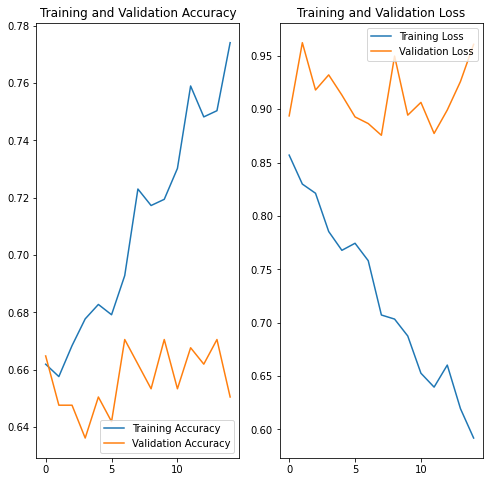

In [624]:
#visualisation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
img_test = "pewdiepie.jpg"
img = keras.preprocessing.image.load_img(
    img_test, target_size=(img_height, img_width)   
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to pewdiepie with a 91.98 percent confidence.


In [627]:
#streamlining above
to_classify = ["shoe.jpg", "hat.jpg", "pants_2.jpg", "shirt_2.jpg"]

for i in to_classify:
    img_test = i
    img = keras.preprocessing.image.load_img(
        img_test, target_size=(img_height, img_width)
    )

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100*np.max(score))
    )


This image most likely belongs to shoes jpg with a 73.22 percent confidence.
This image most likely belongs to hat jpg with a 56.99 percent confidence.
This image most likely belongs to pants jpg with a 99.14 percent confidence.
This image most likely belongs to hat jpg with a 58.25 percent confidence.
